The following cell contains all the functions needed to construct the photoacoustic imaging forward matrix. The algorithm is based on the paper "Curve-Driven-Based Acoustic Inversion for Photoacoustic Tomography" by Liu et al (DOI: 10.1109/TMI.2016.2584120) . The algorithm is abbreviated as CDMMI.

Some difference from the paper: The forward matrix assumes that the ultrasound transducer has infinite bandwidth and the source consist of square shaped pixels, which whose correspoding ultrasound emission frequency goes to infinity due to the sharp edges. This means that the Nyquist principle can never be satisfied with finite sampling frequency. In order to reduce the aliasing, we use very higher sampling frequency and then filter the columns of the matrix with using antialiasing filter, and then down sample the columns again. This will simulate the real process when the transducer has a finite bandwidth.

This code is used for the course CS101 only.

In [ ]:
import numpy as np
from scipy.fft import fft, ifft
import scipy.signal as signal

def isInRange(theta, theta1, theta2):
  # This function computes the logical value of whether theta lies inside the
  # arc defined by counter clockwise rotating from theta1 to theta2.

  return ((theta - theta1) % (2 * np.pi)) <= ((theta2 - theta1) % (2 * np.pi))

def intersectHlineAndCircle(x_r, y_r, R, y_line):
  # This function computes the coordinate of intersection points of a circle
  # centered at x_r, y_r with a radius of R and a horizontal line whose y
  # coordinate is y_line.

  if abs(y_r - y_line) >= R: # if there is no intersection point
    # tangency is not counted as intersection
    x = np.zeros(0) # empty array
    y = np.zeros(0)
    theta = np.zeros(0)
    return (x, y, theta)
  else:
    theta1 = np.arcsin((y_line - y_r) / R)
    theta2 = np.pi - theta1
    y = np.hstack((y_line, y_line))

    theta = np.hstack((theta1, theta2))
    x = x_r + R * np.cos(theta)
    return (x, y, theta)

def intersectVlineAndCircle(x_r, y_r, R, x_line):
  # This function computes the coordinate of intersection points of a circle
  # centered at x_r, y_r with a radius of R and a verytical line whose x
  # coordinate is x_line.

  if abs(x_r - x_line) >= R:
    # tangency is not counted as intersection
    x = np.zeros(0)
    y = np.zeros(0)
    theta = np.zeros(0)
    return (x, y, theta)
  else:
    theta1 = np.arccos((x_line - x_r) / R)
    theta2 = - theta1
    x =  np.hstack((x_line, x_line))

    theta = np.hstack((theta1, theta2))
    y = y_r + R * np.sin(theta)
    return (x, y, theta)

def angleRangeCDMMI(x1, x2, y1, y2, x_r, y_r, R):
# This function calculates the range of the angle on the circle centered at
# x_r, y_r with a radius of R that lies inside the rectangle whose x and y
# limites are given by x1, x2, y1 and y2. The returned value is either an array
# of size 4 if the range contains two intervals, or an array of size 2 if the
# range contains one interval. If the circle does not intersect with the
# rectangle then return an empty array.

  (xh1, t, thetah1) = intersectHlineAndCircle(x_r, y_r, R, y1)
  (xh2, t, thetah2) = intersectHlineAndCircle(x_r, y_r, R, y2)
  xh      = np.hstack((xh1, xh2))
  thetah  = np.hstack((thetah1, thetah2))
  idh = np.logical_and(xh <= x2, xh >= x1)
  thetah = thetah[idh]
  # Compute the intersection points on the two horizontal lines and select
  # those points between the two vertical lines.

  (t, yv1, thetav1) = intersectVlineAndCircle(x_r, y_r, R, x1)
  (t, yv2, thetav2) = intersectVlineAndCircle(x_r, y_r, R, x2)
  yv      = np.hstack((yv1,yv2))
  thetav  = np.hstack((thetav1,thetav2))
  idv = np.logical_and(yv <= y2, yv >= y1)
  thetav = thetav[idv]
  # Compute the intersection points on the two vertical lines and select
  # those points between the two horizontal lines.

  theta = np.hstack((thetah,thetav))
  # Stack the radius angle of the points

  if theta.shape[0] == 0:
    theta_range = theta
    return theta_range
    # If there is no intersection point, returen an empty array

  theta = (theta - theta[0]) % (2 * np.pi) + theta[0]
  theta = np.sort(theta)
  theta = np.unique(theta)
  # Make the angles in accending order and delete repeated values

  theta_mid = theta[0] + (theta[1] - theta[0]) % (2 * np.pi) / 2
  x_mid = x_r + R * np.cos(theta_mid)
  y_mid = y_r + R * np.sin(theta_mid)
  # There could be either 4 intersection points or 2 intersection points.
  # The circle will be cut into 4 or 2 arcs. By checking whether the middle
  # point on the arc is in the rectangle we can determine which two or one arc
  # is that we want.

  if x_mid > x1 and x_mid < x2 and y_mid > y1 and y_mid < y2:
    theta_range = theta
    # If the first arc (middle point) is in the rectangle, we don't need to
    # change the order because it must be the first or the first and third arc
    # that is in the rectangle.
  else:
    if theta.shape[0] == 2:
        theta_range = np.hstack((theta[1], theta[0]))
        # If the first arc is not selected, the other half will be selected
    else:
        theta_range = np.hstack((theta[3], theta[0:3]))
        # If the first arc is not selected, the second and fourth will be selected
  return theta_range

def deltaThetaCDMMI(xs, ys, px, py, x_r, y_r, R):
  # This function calculate the angle arc values of a circle centered at x_r,
  # y_r with a radius of R being cut by grids made of vertical and horizontal
  # lines defined by xs and ys.

  x_id = np.zeros(0)
  y_id = np.zeros(0)
  delta_theta = np.zeros(0)
  # First asign empty arrays because we need to return something even if in the
  # end we find no intersections.

  theta_range = angleRangeCDMMI(xs[0], xs[-1], ys[0], ys[-1], x_r, y_r, R)
  if theta_range.shape[0] == 0:
    return (x_id, y_id, delta_theta)
  # Calculate the angle range of the circle that intersect with the rectangle
  # field of view.

  vlines_x        = xs[abs(xs - x_r) <= R]
  # These are the vertical lines that may intersect with the circle

  vlines_theta1   = np.arccos((vlines_x - x_r) / R)
  vlines_theta2   = - vlines_theta1
  vlines_theta    = np.hstack((vlines_theta1, vlines_theta2))
  # Calculate the radius angle of these intersection points

  hlines_y        = ys[abs(ys - y_r) <= R]
  # These are the horizontal lines that may intersect with the circle

  hlines_theta1   = np.arcsin((hlines_y - y_r) / R)
  hlines_theta2   = np.pi - hlines_theta1
  hlines_theta    = np.hstack((hlines_theta1, hlines_theta2))
  # Calculate the radius angle of these intersection points

  theta_comb  = np.hstack((vlines_theta, hlines_theta))
  # Combine all the intersection points together

  if theta_range.shape[0] == 2:
    is_in_range = isInRange(theta_comb, theta_range[0], theta_range[1])
    theta_comb  = theta_comb[is_in_range]
    theta_comb  = np.hstack((theta_comb, theta_range))
    # Because of some numerical errors, the edge may be in the end not included
    # here we add the edges manually
    theta_comb  = ((theta_comb - theta_range[0]) % (2 * np.pi)) + theta_range[0]
    theta_comb  = np.sort(theta_comb)
    theta_comb  = np.unique(theta_comb)
    # Select the intersection points that is inside the field of view using the
    # angle range. Then sort them in accending order and remove repeated points.

    delta_theta = theta_comb[1:] - theta_comb[:-1]
    theta_mid   = (theta_comb[1:] + theta_comb[:-1]) / 2
    # Calculate the middle points of the arcs formed between these points

    x_id = np.ceil((R * np.cos(theta_mid) + x_r - xs[0]) / px) - 1
    y_id = np.ceil((R * np.sin(theta_mid) + y_r - ys[0]) / py) - 1
    # From the middle point coordinates calculate the pixel index that arc lies
    # in the grids by rounding.

    x_id[x_id < 0] = 0
    x_id[x_id >= xs.shape[0]-1] = xs.shape[0] - 2
    y_id[y_id < 0] = 0
    y_id[y_id >= ys.shape[0]-1] = ys.shape[0] - 2
    # In theory the integers will not go outside the range. But because of some
    # numerical error, this can happen and we need to fix it.

  elif theta_range.shape[0] == 4:
    is_in_range1    = isInRange(theta_comb, theta_range[0], theta_range[1])
    is_in_range2    = isInRange(theta_comb, theta_range[2], theta_range[3])
    theta_comb1 = theta_comb[is_in_range1]
    theta_comb1 = np.hstack((theta_comb1, theta_range[:2]))
    # Because of some numerical errors, the edge may be in the end not included
    # here we add the edges manually
    theta_comb2 = theta_comb[is_in_range2]
    theta_comb2 = np.hstack((theta_comb2, theta_range[2:]))
    # Because of some numerical errors, the edge may be in the end not included
    # here we add the edges manually
    theta_comb1  = (theta_comb1 - theta_range[0]) % (2 * np.pi) + theta_range[0]
    theta_comb1  = np.sort(theta_comb1)
    theta_comb1  = np.unique(theta_comb1)
    theta_comb2  = (theta_comb2 - theta_range[2]) % (2 * np.pi) + theta_range[2]
    theta_comb2  = np.sort(theta_comb2)
    theta_comb2  = np.unique(theta_comb2)
    # Select the intersection points that is inside the field of view using the
    # angle range. Then sort them in accending order and remove repeated points.

    delta_theta1 = theta_comb1[1:] - theta_comb1[:-1]
    theta_mid1   = (theta_comb1[1:] + theta_comb1[:-1]) / 2
    delta_theta2 = theta_comb2[1:] - theta_comb2[:-1]
    theta_mid2   = (theta_comb2[1:] + theta_comb2[:-1]) / 2
    theta_mid   = np.hstack((theta_mid1, theta_mid2))
    delta_theta = np.hstack((delta_theta1, delta_theta2))
    # Calculate the middle points of the arcs formed between these points

    x_id = np.ceil((R * np.cos(theta_mid) + x_r - xs[0]) / px) - 1
    y_id = np.ceil((R * np.sin(theta_mid) + y_r - ys[0]) / py) - 1
    # From the middle point coordinates calculate the pixel index that arc lies
    # in the grids by rounding.

    x_id[x_id < 0] = 0
    x_id[x_id >= xs.shape[0]-1] = xs.shape[0] - 2
    y_id[y_id < 0] = 0
    y_id[y_id >= ys.shape[0]-1] = ys.shape[0] - 2
    # In theory the integers will not go outside the range. But because of some
    # numerical error, this can happen and we need to fix it.

  return (x_id, y_id, delta_theta)

def forwardMatrixFullRingCDMMI(N_transducer, R_ring, px, py, M, N, dt, N_sample, oversample, padsample, T_min, Band, V_sound):
# This function computes the forward matrix of ring array photoacoustic imaging
# given the parameters of the system.
# N_transducer
#             the number of transducers evenly distributed on the array
# R_ring
#             the radius of the array [m]
# px and py
#             the pixel size in x and y direction [m]
# M and N
#             the pixel number in y and x direction
# dt
#             the time sampling interval [s]
# N_sample
#             the number of time domain samples
# oversample
#             the oversample factor, we first will first have
#             2 * oversample * N_sample points then filter and downsample
#             to get the N_sample points
# padsample
#             we also compute padsample more samples before and after the
#             2 * oversample * N_sample points before filtering and downsampling
# T_min
#             the time of the first sampling point (time zero is the laser shot)
# Band
#             the one side bandwidth (3dB) of the system,
#             filtering done by hanning window
# V_sound
#             the speed of sound [m/s]
# The function will return the forward matrix A and the sample time serie
#  t_sample and also the pixel coordinate x_sample and y_sample

  T_max = T_min + (N_sample - 1) * dt
  t_sample = dt * np.linspace(T_min, T_max, num = N_sample)

  delta_angle = 2 * np.pi / N_transducer
  angle_transducer = delta_angle * np.linspace(1, N_transducer, num = N_transducer)

  transducer_x = R_ring * np.sin(angle_transducer)
  transducer_y = R_ring * np.cos(angle_transducer)
  # Compute the transducer coordinate, they are evenly distributed on a ring

  xs = np.linspace(0, N, num = N + 1) * px - px * N / 2
  ys = np.linspace(0, M, num = M + 1) * py - py * M / 2
  x_sample = xs[:-1] + px / 2
  y_sample = ys[:-1] + py / 2
  # Compute the gird boundaries xs and xy and from which compute the pixel center coordinates

  dt_oversample = dt / 2 / oversample
  t_over_sample = np.linspace(T_min - dt_oversample  * (oversample + padsample - 0.5),\
                              T_max + dt_oversample  * (oversample + padsample - 0.5),\
                              N_sample * 2 * oversample + 2 * padsample)

  A = np.zeros([M, N, N_transducer, t_over_sample.shape[0]])
  # Allocate space for the matrix

  for r in range(0, N_transducer):
    for t in range(0, t_over_sample.shape[0]):
      [x_id, y_id, delta_theta] = deltaThetaCDMMI(xs, ys, px, py, transducer_x[r], transducer_y[r], t_over_sample[t] * V_sound)
      for k in range(0, delta_theta.shape[0]):
        A[int(y_id[k]), int(x_id[k]), r, t] = A[int(y_id[k]), int(x_id[k]), r, t] + delta_theta[k]
  # First asign the arc values to the matrix elements

  #display(t_over_sample.shape)

  A = A[:, :, :, 1:] - A[:, :, :, :-1]
  # Then take the derivative operation

  # Lowpass filtering using hanning window
  A =  fft(A, axis = -1)

  B = int(np.ceil(Band / (1 / dt_oversample / A.shape[-1])))
  window = np.zeros(A.shape[-1])
  window[0:4 * B + 1] = signal.hanning(4 * B + 1)
  window = np.roll(window, -2 * B)

  A = A * window
  A = ifft(A, axis = -1).real
  #display(A.shape)
  A = A[:, :, :, oversample + padsample - 2:-padsample:2 * oversample]
  #display(A.shape)
  A = A.reshape((M * N, N_transducer * t_sample.shape[0]))
  return (A, x_sample, y_sample, t_sample)

To construct a forward matrix, just specify the parameters and run this cell. To simulate a case when you have limited view or sparse sampling, there are two ways. The first way is to directly crop the matrix A by deleting some rows. The second way is to change the transducer coordinate generated in the function forwardMatrixFullRingCDMMI.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:291: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!


16.490207124826547


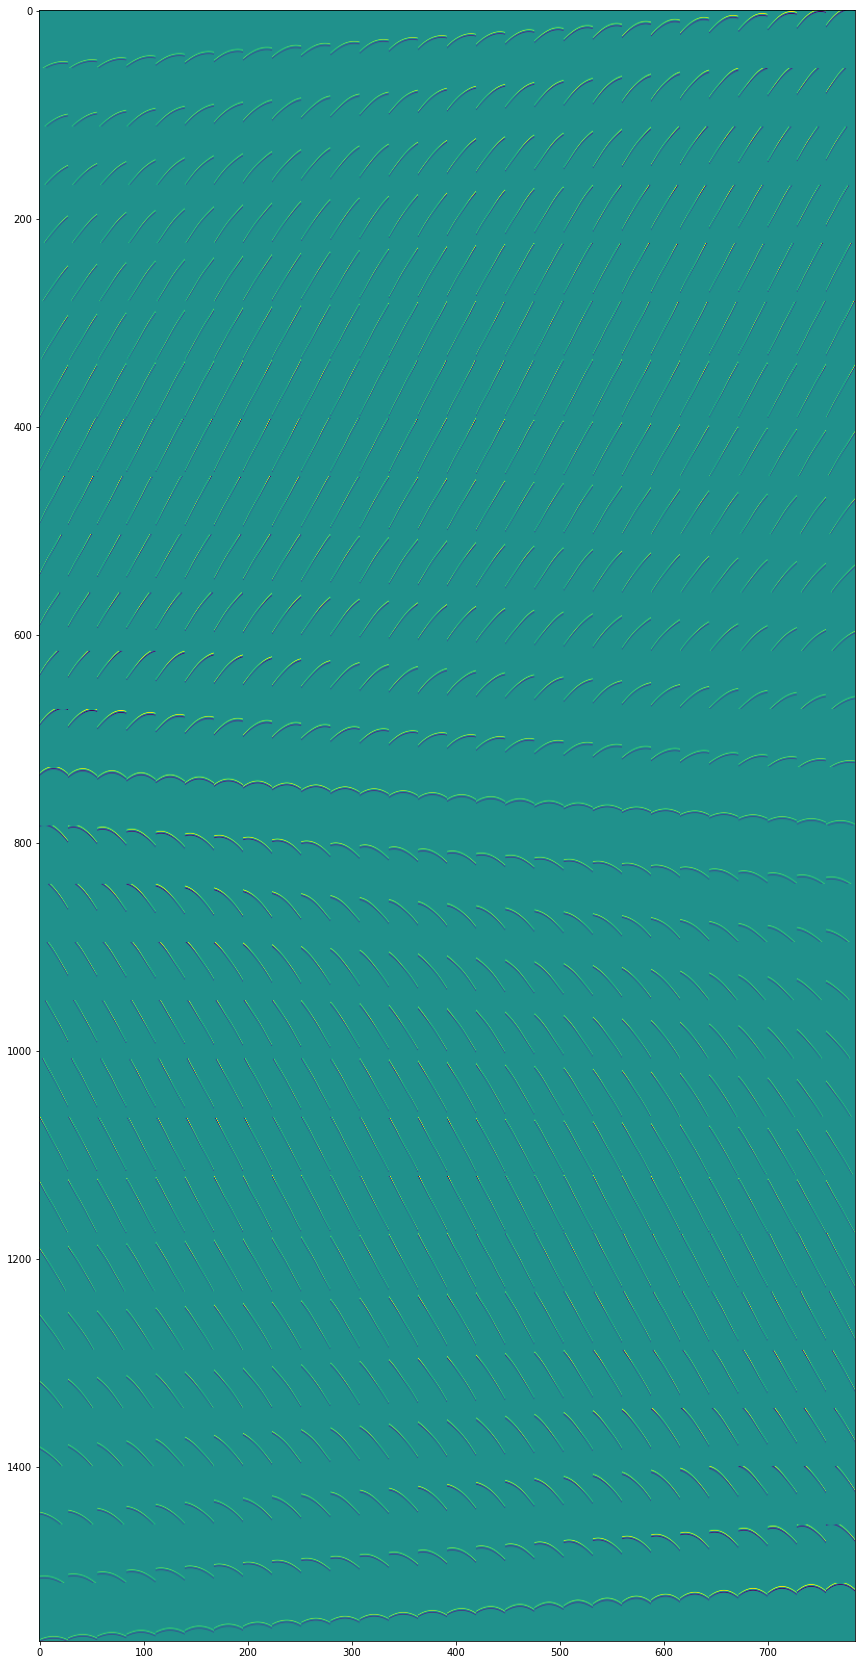

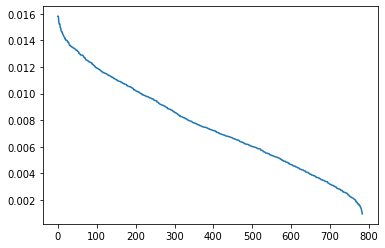

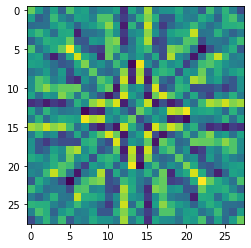

In [ ]:
from matplotlib import pyplot as plt

# Fixed parameters
R_ring         = 0.04
M              = 28
N              = 28
V_sound        = 1500
px             = 1e-3
py             = 1e-3

# Free parameters
N_sample       = 56
N_transducer   = 28

T_min = (R_ring - py * (M / 2 - 0.5)) / V_sound
T_max = np.sqrt((R_ring + py * (M / 2 - 0.5))**2 + (px * (N / 2 - 0.5))**2) / V_sound
dt    = (T_max - T_min) / (N_sample - 1)

oversample  = 10
padsample   = 50
Band        = 1 /dt / 2


(A, x_sample, y_sample, t_sample) = forwardMatrixFullRingCDMMI(N_transducer, R_ring, px, py, M, N, dt, N_sample, oversample, padsample, T_min, Band, V_sound)

plt.figure(figsize = (30,30))
plt.imshow(A.T)

print(np.linalg.cond(A.T))

U, D, VT = np.linalg.svd(A.T)

plt.figure()
plt.plot(D)

plt.figure()
plt.imshow(VT[-1, :].reshape(N, M).T)


Now let us take a close look at one column of the matrix. The physical meaning is: what the measured signals will look as if the to-be-imaged object is a one-hot vector.

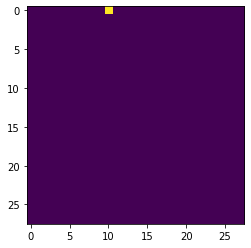

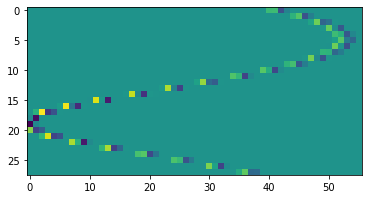

In [ ]:
x_hot = 0
y_hot = 10
# This is the coordinate of the pixel

col_id = y_hot * N + x_hot
delta_col = np.zeros([A.shape[0], 1])
delta_col[col_id] = 1
# Generate the one-hot vector

A_col = A[col_id, :]
# Pick out the column of the matrix

plt.figure()
plt.imshow(delta_col.reshape(N, M).T)
# This is the one-hot image

plt.figure()
plt.imshow(A_col.reshape(N_transducer, t_sample.shape[0]))
# This is the corresponding signals


Now let's take a look at one row of the matrix. The physical meaning is that at one time point acquired by one transducer, what is the contribution of each different pixel. In fact, the pixels that can contribute to the given data point should roughly lie on a circle centered at the transducer coordinate with a radius of V_sound * time.

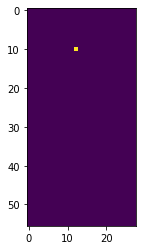

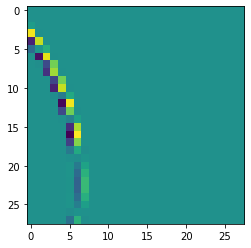

In [ ]:

transducer_id = 12
time_id = 10
# The index of the transducer and the time domain sample point
row_id = transducer_id * t_sample.shape[0] + time_id
delta_row = np.zeros([A.shape[1], 1])
delta_row[row_id] = 1
A_row = A[:, row_id]
# Pick out the row of the matrix

plt.figure()
plt.imshow(delta_row.reshape(N_transducer, t_sample.shape[0]).T);

# This is the indicator of the data point in the signal domain
plt.figure()
plt.imshow(A_row.reshape(N, M).T)

# This is the contribution of all the pixels to that data point (one row of the matrix)

# **Using the Forward Matrix in a Diffusion Model**

In [ ]:
#@title Model Setup: ScoreNet

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, output_padding=0)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    # print("h3: ", end='')
    # print(h3.shape)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path

    # print("h4: ", end='')
    # print(h4.shape)

    h = self.tconv4(h4)

    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)

    # print("h: ", end='')
    # print(h.shape)

    # print("END")
    # print(h3.shape)

    h = self.tconv3(torch.cat([h, h3], dim=1))



    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
#@title Model Setup: SDE

device = 'cuda'

# default sde setup

def default_marginal_prob_std(t, sigma):
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def default_diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=device)

sigma_default =  5
default_marginal_prob_std_fn = functools.partial(default_marginal_prob_std, sigma=sigma_default)
default_diffusion_coeff_fn = functools.partial(default_diffusion_coeff, sigma=sigma_default)


# variance exploding setup

def ve_marginal_prob_std(t,sigma_min,sigma_max):
    std = sigma_min * (sigma_max / sigma_min) ** t
    return std

def ve_diffusion_coeff(t,sigma_min,sigma_max):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(sigma_max) - np.log(sigma_min)),
                                                device=t.device))
    return diffusion

sigma_min_ve = 0.01
sigma_max_ve = 5
ve_marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma_min=sigma_min_ve, sigma_max=sigma_max_ve)
ve_diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma_min=sigma_min_ve, sigma_max=sigma_max_ve)


# sub variance preserving setup

def subvp_marginal_prob_std(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    std = 1 - torch.exp(2. * log_mean_coeff)
    return std

def subvp_diffusion_coeff(t, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    discount = 1. - torch.exp(-2 * beta_min * t - (beta_max - beta_min) * t ** 2)
    diffusion = torch.sqrt(beta_t * discount)
    return diffusion

def subvp_drift_coeff(t, x, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    if beta_t.dim() == 0:
        drift = -0.5 * beta_t * x
    else:
        drift = -0.5 * beta_t[:, None, None, None] * x
    return drift

beta_min_subvp = 0.01
beta_max_subvp = 5
subvp_marginal_prob_std_fn = functools.partial(subvp_marginal_prob_std, beta_min=beta_min_subvp, beta_max=beta_max_subvp)
subvp_diffusion_coeff_fn = functools.partial(subvp_diffusion_coeff, beta_min=beta_min_subvp, beta_max=beta_max_subvp)
subvp_drift_coeff_fn = functools.partial(subvp_drift_coeff, beta_min=beta_min_subvp, beta_max=beta_max_subvp)


# variance preserving setup

def vp_marginal_prob_std(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
    return std

def vp_diffusion_coeff(t, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    diffusion = torch.sqrt(beta_t)
    return diffusion

def vp_drift_coeff(t, x, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    if beta_t.dim() == 0:
        drift = -0.5 * beta_t * x
    else:
        drift = -0.5 * beta_t[:, None, None, None] * x
    return drift

beta_min_vp = .01
beta_max_vp = 5
vp_marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, beta_min=beta_min_vp, beta_max=beta_max_vp)
vp_drift_coeff_fn = functools.partial(vp_drift_coeff, beta_min=beta_min_vp, beta_max=beta_max_vp)
vp_diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, beta_min=beta_min_vp, beta_max=beta_max_vp)



# so that we can conveniently change the sde for the rest of the code

sde = 'VE'

marginal = None
diffusion_coeff = None
drift_coeff = None
model_name = None

if sde == 'VE':
  marginal = ve_marginal_prob_std_fn
  diffusion_coeff = ve_diffusion_coeff_fn
  model_name = 'ckpt_ve.pth'
elif sde == 'VP':
  marginal = vp_marginal_prob_std_fn
  diffusion_coeff = vp_diffusion_coeff_fn
  drift_coeff = vp_drift_coeff_fn
  model_name = 'ckpt_vp.pth'
elif sde == 'subVP':
  marginal = subvp_marginal_prob_std_fn
  diffusion_coeff = subvp_diffusion_coeff_fn
  drift_coeff = subvp_drift_coeff_fn
  model_name = 'ckpt_subvp.pth'
else:
  marginal = default_marginal_prob_std_fn
  diffusion_coeff = default_diffusion_coeff_fn
  model_name = 'ckpt_default.pth'


In [ ]:
#@title Model Setup: Loss Function

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
from pickleshare import print_function
#@title Model Setup: EM Sampler

def rinv(B):
  # invB = B^T(BB^T)^-1
  return torch.matmul(torch.t(B), torch.inverse(torch.matmul(B, torch.t(B))))


def linv(B):
  return torch.matmul(torch.inverse(torch.matmul(B.T, B)), B.T)


# progressive perturbation fn
def perturb(x, t, marginal_prob_std):
    std = marginal_prob_std(t)
    z = torch.randn_like(x)
    return x + z * std.unsqueeze(0)[:, None]


def Euler_Maruyama_general_inverse_sampler(y0,
                                           P,
                                           Lamb,
                                           T,
                                           score_model,
                                           marginal_prob_std,
                                           diffusion_coeff,
                                           drift_coeff,
                                           batch_size=64,
                                           num_steps=500,
                                           device='cuda',
                                           eps=1e-3,
                                           lamb=0.05):

  # sample x from pt
  t = torch.ones(1, device=device) # scalar
  xt = torch.randn(28, 28, device=device) * marginal_prob_std(t)[:, None] # 28x28 matrix

  print()

  # set up time steps
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  lamb_schedule = lamb / num_steps

  # y vector
  y = [perturb(y0, time_step, marginal_prob_std) for time_step in time_steps]


  x = xt
  idx = 0
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      # reverse sde to get initial xi
      g = diffusion_coeff(time_step)
      g2 = (g**2).unsqueeze(0)[:, None]

      repeat_score = score_model(x.unsqueeze(0).repeat(32,1,1,1).float(), torch.full((32,) , time_step, device=x.device))
      score = repeat_score[0].squeeze()

      mean_x = None
      if drift_coeff == None:
        mean_x = x + g2 * score * step_size
      else:
        f = drift_coeff(time_step, x).unsqueeze()[:, None]
        mean_x = x + (-1 * f + (g2 * score)) * step_size

      x = mean_x + torch.sqrt(step_size) * g.unsqueeze(0)[:, None] * torch.randn_like(x)

      # then constrain x by y

      # set up y
      yi = y[idx].squeeze()
      idx += 1

      # flatten x and y into column vectors
      xflat = x.reshape((-1))

      # calculate closed form solution
      term1 = lamb * torch.matmul(torch.matmul(Lamb, rinv(P)), yi)
      term2 = (1 - lamb) * torch.matmul(torch.matmul(Lamb, T), xflat.float())
      term3 = torch.matmul((torch.eye(T.shape[0]).to(device) - Lamb), torch.matmul(T, xflat.float()))
      xflat = torch.matmul(linv(T), term1 + term2 + term3)


      # print()
      # print(term1[10])
      # print(term2[10])
      # print(xflat[10])

      # restore x and decrement lamb
      x = xflat.reshape((28, 28))

      # plt.figure()
      # plt.imshow(x)

      # if idx == num_steps / 1.1:
      #   lamb = 0.05

  return x, yi

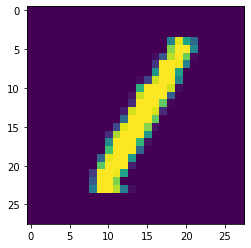

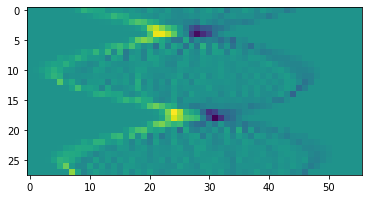

In [ ]:
#@title Input Setup


import numpy as np
import torch
from torchvision.utils import make_grid
import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# getting an input image

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
images, _ = next(iter(data_loader))

x = images[0]

plt.figure()
plt.imshow(x.squeeze())

# x = x.to('cuda')




# make well conditioned gaussian T
T = torch.tensor(A.T).float()
# T = torch.normal(0, 1, size=(28**2,28**2))#.to('cuda')
# U, S, V = torch.linalg.svd(T)
# T = torch.matmul(U, torch.t(V))



# P(Lamb)T definitions


# Defining P to downsample
P = torch.eye(T.shape[0])
# P = torch.eye(28**2)
# keep = [i for i in range(28**2)]
# random.shuffle(keep)
# keep = torch.sort(torch.tensor(keep[0:300]))[0]
# P = torch.index_select(P, 0, keep)#.to('cuda')


# Lamb is a subsampling mask
Lamb = torch.eye(T.shape[0])
# Lamb = torch.eye(28**2)
# Lamb = torch.zeros((28**2, 28**2))#.to('cuda')
# for i in range(keep.size()[0]):
#   Lamb[keep[i], keep[i]] = 1


# get y from x
A_forward = torch.matmul(torch.matmul(P, Lamb), T)
y = torch.matmul(A_forward, x.reshape((-1, 1)))


plt.figure()
plt.imshow(y.reshape(28,56))

In [ ]:
device = 'cpu'

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal))
score_model = score_model.to(device)

# Load the pre-trained checkpoint from disk.
ckpt = torch.load(model_name, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 32
sampler = Euler_Maruyama_general_inverse_sampler

# Generate samples using the specified sampler.
xi, yi = sampler(y.to(device),
                 P,
                 Lamb,
                 T,
                 score_model,
                 marginal,
                 diffusion_coeff,
                 drift_coeff,
                 sample_batch_size,
                 device=device
                 )

# Sample visualization.
plt.imshow(xi.reshape((28,28)).squeeze().to('cpu'))

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(np.linalg.cond(torch.matmul(T, T.T)))

96431190000.0
